In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import statistics
import math
import matplotlib.pyplot as plt
from unidecode import unidecode
from collections import Counter
import numpy as np


def binary_ci(success, total, alpha=0.95):
    """
    Using Agresti-Coull interval
    
    Return mean and confidence interval (lower and upper bound)
    """
    z = statistics.NormalDist().inv_cdf((1 + alpha) / 2)
    total = total + z**2
    loc = (success + (z**2) / 2) / total
    diameter = z * math.sqrt(loc * (1 - loc) / total)
    return loc, loc - diameter, loc + diameter 


def set_size(w,h, ax=None):
    """
    Used to size the figures with subplots
    
    https://stackoverflow.com/questions/44970010/axes-class-set-explicitly-size-width-height-of-axes-in-given-units
    """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)


In [3]:
sentences = []
stereotypes = []

for line in open('sentences.txt'):
    words = line.split()
    sentences.append(' '.join(words[:-1]))
    stereotypes.append(int(words[-1]))

stereo_names = """
Emotional
Gentle
Empathetic
Neat
Social
Weak
Beautiful
Tough and rough
Self-confident
Professional
Rational
Providers
Leaders
Childish
Sexual
Strong
""".strip().split('\n')

In [4]:
"""
Retrieving unsaved translations from logs
"""

# import os
# google_translate = GoogleTranslate(
#     data_path='./cache/translations/google_translate',
#     target_language=target_language,
#     enable_api=False
# ).load()

# for i in range(1, 201):
#     fdir = '/labs/cache/translations/google_translate/cs/logs'
#     fin, fout = os.path.join(fdir, f'{i}.from'), os.path.join(fdir, f'{i}.to')
#     from_, to_ = open(fin).read(), open(fout).read()
#     if from_ not in google_translate.dataframe.index:
#         google_translate.dataframe.loc[from_] = to_

# google_translate.save()

'\nRetrieving unsaved translations from logs\n'

In [6]:
from unidecode import unidecode
from parser import Parser
from translators.google_translate import GoogleTranslate
from translators.amazon_translate import AmazonTranslate


for target_language in ['hr', 'cs', 'pl', 'ru', 'sl', 'sk', 'sr', 'uk']:
    google_translate = AmazonTranslate(
        data_path='./cache/translations/amazon_translate',
        target_language=target_language,
        enable_api=True
    ).load()
    parser = Parser(language=target_language).load_model()
    for x in range(len(sentences)//100 + 1):   
    # for x in range(1):   
        translations = google_translate.translate(sentences[x*100: x*100 + 100], save=True)
        parser.parse(list(translations.values()))
# google_translate = GoogleTranslate(
#     data_path='./cache/translations/google_translate',
#     target_language=target_language,
#     enable_api=False
# ).load()


INFO:translators.translator:Loaded translations: 100
INFO:trankit.adapter_transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-sentencepiece.bpe.model from cache at cache/trankit/xlm-roberta-base/0c370616ddfc06067c0634160f749c2cf9d8da2c50e03a2617ce5841c8df3b1d.309f0c29486cffc28e1e40a2ab0ac8f500c203fe080b95f820aa9cb58e5b84ed


Loading pretrained XLM-Roberta, this may take a while...


INFO:trankit.adapter_transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-config.json from cache at cache/trankit/xlm-roberta-base/762ddd751172e9d3229e5da17a459eee6c0dfdc237c718944d0b1a85f06c7e1e.2b0f807393c56e8861a31cd67d2fc0b45d71d9735dd47dd66afb650f90b6d2a8
INFO:trankit.adapter_transformers.configuration_utils:Model config XLMRobertaConfig {
  "adapters": {
    "adapters": {},
    "config_map": {}
  },
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "output_past": true,
  "pad_token_id": 1,
  "type_vocab_size": 1

Loading tokenizer for croatian
Loading tagger for croatian
Loading lemmatizer for croatian
Active language: croatian


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.60it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 200
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.63it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 300
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.47it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 400
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.77it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 500
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00

Loading pretrained XLM-Roberta, this may take a while...


INFO:trankit.adapter_transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-config.json from cache at cache/trankit/xlm-roberta-base/762ddd751172e9d3229e5da17a459eee6c0dfdc237c718944d0b1a85f06c7e1e.2b0f807393c56e8861a31cd67d2fc0b45d71d9735dd47dd66afb650f90b6d2a8
INFO:trankit.adapter_transformers.configuration_utils:Model config XLMRobertaConfig {
  "adapters": {
    "adapters": {},
    "config_map": {}
  },
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "output_past": true,
  "pad_token_id": 1,
  "type_vocab_size": 1

Loading tokenizer for czech
Loading tagger for czech
Loading multi-word expander for czech
Loading lemmatizer for czech
Active language: czech


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.35it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 200
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.19it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 300
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.38it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 400
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.35it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 500
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00

Loading pretrained XLM-Roberta, this may take a while...


INFO:trankit.adapter_transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-config.json from cache at cache/trankit/xlm-roberta-base/762ddd751172e9d3229e5da17a459eee6c0dfdc237c718944d0b1a85f06c7e1e.2b0f807393c56e8861a31cd67d2fc0b45d71d9735dd47dd66afb650f90b6d2a8
INFO:trankit.adapter_transformers.configuration_utils:Model config XLMRobertaConfig {
  "adapters": {
    "adapters": {},
    "config_map": {}
  },
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "output_past": true,
  "pad_token_id": 1,
  "type_vocab_size": 1

Loading tokenizer for polish
Loading tagger for polish
Loading multi-word expander for polish
Loading lemmatizer for polish
Active language: polish


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.40it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 200
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.27it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 300
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.37it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 400
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.23it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 500
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00

Loading pretrained XLM-Roberta, this may take a while...


INFO:trankit.adapter_transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-config.json from cache at cache/trankit/xlm-roberta-base/762ddd751172e9d3229e5da17a459eee6c0dfdc237c718944d0b1a85f06c7e1e.2b0f807393c56e8861a31cd67d2fc0b45d71d9735dd47dd66afb650f90b6d2a8
INFO:trankit.adapter_transformers.configuration_utils:Model config XLMRobertaConfig {
  "adapters": {
    "adapters": {},
    "config_map": {}
  },
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "output_past": true,
  "pad_token_id": 1,
  "type_vocab_size": 1

Loading tokenizer for russian
Loading tagger for russian
Loading lemmatizer for russian
Loading NER tagger for russian
Active language: russian


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.38it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 200
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.32it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 300
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.27it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 400
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.12it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 500
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00

Loading pretrained XLM-Roberta, this may take a while...


INFO:trankit.adapter_transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-config.json from cache at cache/trankit/xlm-roberta-base/762ddd751172e9d3229e5da17a459eee6c0dfdc237c718944d0b1a85f06c7e1e.2b0f807393c56e8861a31cd67d2fc0b45d71d9735dd47dd66afb650f90b6d2a8
INFO:trankit.adapter_transformers.configuration_utils:Model config XLMRobertaConfig {
  "adapters": {
    "adapters": {},
    "config_map": {}
  },
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "output_past": true,
  "pad_token_id": 1,
  "type_vocab_size": 1

Loading tokenizer for slovenian
Loading tagger for slovenian
Loading lemmatizer for slovenian
Active language: slovenian


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.61it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 200
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.53it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 300
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.44it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 400
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.23it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 500
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00

Loading pretrained XLM-Roberta, this may take a while...


INFO:trankit.adapter_transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-config.json from cache at cache/trankit/xlm-roberta-base/762ddd751172e9d3229e5da17a459eee6c0dfdc237c718944d0b1a85f06c7e1e.2b0f807393c56e8861a31cd67d2fc0b45d71d9735dd47dd66afb650f90b6d2a8
INFO:trankit.adapter_transformers.configuration_utils:Model config XLMRobertaConfig {
  "adapters": {
    "adapters": {},
    "config_map": {}
  },
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "output_past": true,
  "pad_token_id": 1,
  "type_vocab_size": 1

Loading tokenizer for slovak
Loading tagger for slovak
Loading lemmatizer for slovak
Active language: slovak


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.12it/s]
INFO:translators.translator:New translations: 3
INFO:translators.translator:Saved translations: 11221
100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.71it/s]
INFO:translators.translator:New translations: 2
INFO:translators.translator:Saved translations: 11223
100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.28it/s]
INFO:translators.translator:New translations: 6
INFO:translators.translator:Saved translations: 11229
100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.77it/s]
INFO:translators.translator:New translations: 3
INFO:translators.translator:Saved translations: 11232
100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00

Loading pretrained XLM-Roberta, this may take a while...


INFO:trankit.adapter_transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-config.json from cache at cache/trankit/xlm-roberta-base/762ddd751172e9d3229e5da17a459eee6c0dfdc237c718944d0b1a85f06c7e1e.2b0f807393c56e8861a31cd67d2fc0b45d71d9735dd47dd66afb650f90b6d2a8
INFO:trankit.adapter_transformers.configuration_utils:Model config XLMRobertaConfig {
  "adapters": {
    "adapters": {},
    "config_map": {}
  },
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "output_past": true,
  "pad_token_id": 1,
  "type_vocab_size": 1

Loading tokenizer for serbian
Loading tagger for serbian
Loading lemmatizer for serbian
Active language: serbian


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.37it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 200
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.55it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 300
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.31it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 400
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.30it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 500
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00

Loading pretrained XLM-Roberta, this may take a while...


INFO:trankit.adapter_transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-config.json from cache at cache/trankit/xlm-roberta-base/762ddd751172e9d3229e5da17a459eee6c0dfdc237c718944d0b1a85f06c7e1e.2b0f807393c56e8861a31cd67d2fc0b45d71d9735dd47dd66afb650f90b6d2a8
INFO:trankit.adapter_transformers.configuration_utils:Model config XLMRobertaConfig {
  "adapters": {
    "adapters": {},
    "config_map": {}
  },
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "output_past": true,
  "pad_token_id": 1,
  "type_vocab_size": 1

Loading tokenizer for ukrainian
Loading tagger for ukrainian
Loading multi-word expander for ukrainian
Loading lemmatizer for ukrainian
Active language: ukrainian


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.52it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 200
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.47it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 300
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.54it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 400
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.51it/s]
INFO:translators.translator:New translations: 100
INFO:translators.translator:Saved translations: 500
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00

In [7]:
from parser import Parser

from gender_heuristics.heuristics import run_heuristics_wrapper
from gender_heuristics.l_be import be_heuristics
from gender_heuristics.l_bg import bg_heuristics
from gender_heuristics.l_cs import cs_heuristics
from gender_heuristics.l_hr import hr_heuristics
from gender_heuristics.l_pl import pl_heuristics
from gender_heuristics.l_sk import sk_heuristics
from gender_heuristics.l_sl import sl_heuristics
from gender_heuristics.l_sr import sr_heuristics
from gender_heuristics.l_ru import ru_heuristics
from gender_heuristics.l_uk import uk_heuristics

heuristics_map = {
    'bg': bg_heuristics,
    'be': be_heuristics,
    'cs': cs_heuristics,
    'hr': hr_heuristics,
    'pl': pl_heuristics,
    'sk': sk_heuristics,
    'sl': sl_heuristics,
    'sr': sr_heuristics,
    'ru': ru_heuristics,
    'uk': uk_heuristics,
}

def predictions(language, lazy):

    google_translate = AmazonTranslate(
        data_path='./cache/translations/amazon_translate',
        target_language=language,
        enable_api=False
    ).load()
    parser = Parser(language=language)

    heuristics = heuristics_map[language]

    h = run_heuristics_wrapper(heuristics, lazy)
    buf = []
    for sentence, stereotype in zip(sentences, stereotypes):
        try:
            translation = google_translate.dataframe.loc[sentence]['to']
        except KeyError:
            continue
        tokens = parser.dict[translation]['sentences'][0]['tokens']
        buf.append(h(translation, tokens))

    return buf
 


In [8]:
preds = {
    lang: predictions(lang, lazy=False)
    for lang in ['be', 'hr', 'cs', 'pl', 'ru', 'sl', 'sk', 'sr', 'uk']
}

lazy_preds = {
    lang: predictions(lang, lazy=True)
    for lang in ['be', 'hr', 'cs', 'pl', 'ru', 'sl', 'sk', 'sr', 'uk']
}

INFO:translators.translator:Loaded translations: 0
INFO:translators.translator:Loaded translations: 3670
INFO:translators.translator:Loaded translations: 3670
INFO:translators.translator:Loaded translations: 3670
INFO:translators.translator:Loaded translations: 3670
INFO:translators.translator:Loaded translations: 3670
INFO:translators.translator:Loaded translations: 11322
INFO:translators.translator:Loaded translations: 3670
INFO:translators.translator:Loaded translations: 3670
INFO:translators.translator:Loaded translations: 0
INFO:translators.translator:Loaded translations: 3670
INFO:translators.translator:Loaded translations: 3670
INFO:translators.translator:Loaded translations: 3670
INFO:translators.translator:Loaded translations: 3670
INFO:translators.translator:Loaded translations: 3670
INFO:translators.translator:Loaded translations: 11322
INFO:translators.translator:Loaded translations: 3670
INFO:translators.translator:Loaded translations: 3670


In [15]:
for lang in ['be', 'hr', 'cs', 'pl', 'ru', 'sl', 'sk', 'sr', 'uk']:
    print(lang, sum(map(bool, lazy_preds[lang])))

be 0
hr 3054
cs 3262
pl 3078
ru 2583
sl 3201
sk 3341
sr 0
uk 2817


# Machine translation results analysis

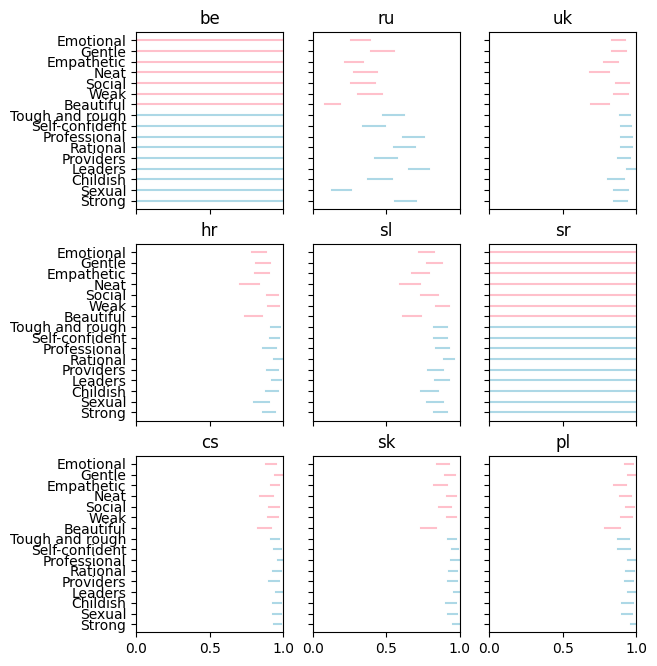

In [9]:
from collections import defaultdict
rates = defaultdict(lambda: list())

fig, axes = plt.subplots(3, 3, sharex=True, sharey=True)
axes = axes.reshape(-1)

for ax, lang in zip(axes, ['be', 'ru', 'uk', 'hr', 'sl', 'sr', 'cs', 'sk', 'pl']):
    for stereotype in range(1, 17):
        labels = [pred for pred, s_id in zip(lazy_preds[lang], stereotypes) if s_id == stereotype]
        male_count = labels.count('male')
        female_count = labels.count('female')
        middle, lower, upper = binary_ci(male_count, male_count + female_count)
        rates[lang].append(middle)
        ax.plot([lower, upper], [stereotype, stereotype], c=('pink' if stereotype < 8 else 'lightblue'))
    ax.set_title(lang)
    ax.set_xlim(0, 1)
    ax.invert_yaxis()
    ax.set_yticks(range(1, 17), stereo_names)
set_size(5, 6)
plt.show()

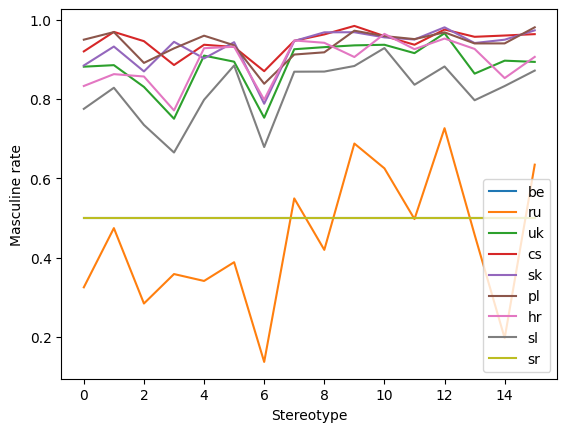

/tmp/ipykernel_59/467852673.py:25: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  plt.colorbar(plt.imshow(np.corrcoef(np.vstack(rates[l] for l in langs))))
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


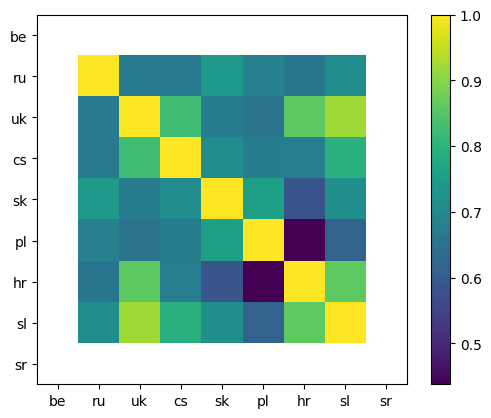

In [10]:
"""
Above:
Male rates as seen for all the languages with different stereotypes. It is clear that the languages
show similar behavior. Either data with similar biases or crosslingual learning.

Below:
Correlations from these plots. How similar different languages behave for these stereotypes.
Seemingly, there are two groups, but I can not tell what the key is (neither geographical, linguistic,
or script make sense). Note that the stereotypes are strong between all of them, so might be just noise.

Some interesting stereotypes:
#7 - Extremely female
#15 - Visible female in the male stereotypes
#2, #5, #6 - Less female overall
"""

langs = ['be', 'ru', 'uk', 'cs', 'sk', 'pl', 'hr', 'sl', 'sr', ]

for l in langs:
    plt.plot(rates[l], label=l)
    plt.legend()
    plt.xlabel('Stereotype')
    plt.ylabel('Masculine rate')
plt.show()
plt.colorbar(plt.imshow(np.corrcoef(np.vstack(rates[l] for l in langs))))
plt.xticks(range(9), langs)
plt.yticks(range(9), langs)
None

/tmp/ipykernel_59/3912354547.py:16: RuntimeWarning: invalid value encountered in scalar divide
  all_m_ratio = sum(counts[:,0]) / np.sum(counts)
/tmp/ipykernel_59/3912354547.py:17: RuntimeWarning: invalid value encountered in scalar divide
  f_m_ratio = sum(counts[:7,0]) / np.sum(counts[:7])
/tmp/ipykernel_59/3912354547.py:18: RuntimeWarning: invalid value encountered in scalar divide
  m_m_ratio = sum(counts[7:,0]) / np.sum(counts[7:])


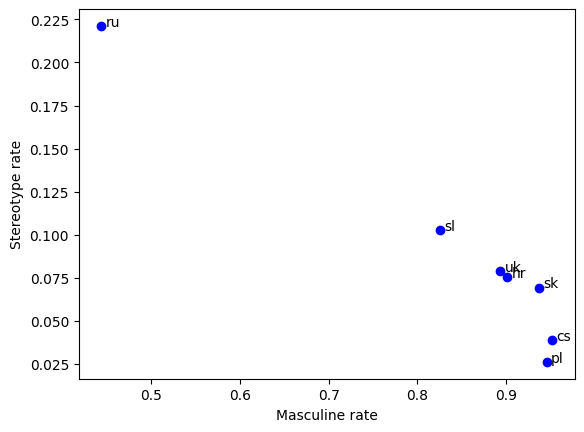

In [11]:
"""
Relation between the masculine rate (how often is masculine gender selected) and the stereotype
rate (how different are the selection rates for male and female stereotypes). It is clear that
there is a trade-off. Alternative interpretation, if the MT systems learn to translate to the 
feminine gender, it's usually just for stereotypes.
"""
for lang in ['be', 'hr', 'cs', 'pl', 'ru', 'sl', 'sk', 'sr', 'uk']:
    counts = np.zeros((16, 2))
    for stereotype in range(1, 17):
        labels = [pred for pred, s_id in zip(lazy_preds[lang], stereotypes) if s_id == stereotype]
        male_count = labels.count('male')
        female_count = labels.count('female')
        counts[stereotype - 1, 0] = male_count
        counts[stereotype - 1, 1] = female_count

    all_m_ratio = sum(counts[:,0]) / np.sum(counts)
    f_m_ratio = sum(counts[:7,0]) / np.sum(counts[:7])
    m_m_ratio = sum(counts[7:,0]) / np.sum(counts[7:])
    plt.scatter([all_m_ratio], [m_m_ratio - f_m_ratio], c='blue')
    plt.text(all_m_ratio + 0.005, m_m_ratio - f_m_ratio, lang)
    plt.xlabel('Masculine rate')
    plt.ylabel('Stereotype rate')
plt.show()
    
    # plt.xlim(0, 1)
    # plt.ylim(0, 1)

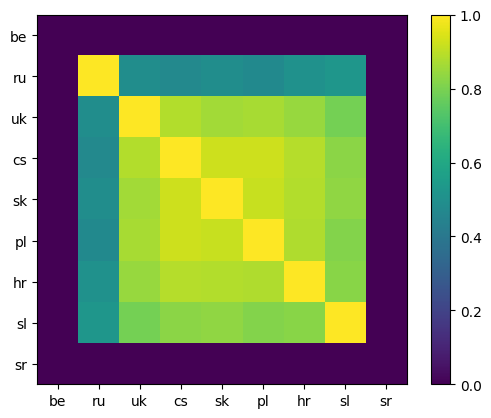

In [20]:
"""
If both languages have predictions, how common it is that they match. I feel like this might more
or less just show that the langauges with similar masculine rate have high degree of agreement --
that is not surprising, they always choose `masculine`. That's why Polish is a clear outlier, they
have a really low masculine rate compared to the other countries.
"""
from itertools import product

langs = ['be', 'ru', 'uk', 'cs', 'sk', 'pl', 'hr', 'sl', 'sr', ]
agree = np.zeros((9, 9))

for i, j in product(langs, langs):
    agree[langs.index(i), langs.index(j)] = sum(
        p == r != None
        for p, r in zip(lazy_preds[i], lazy_preds[j])
    ) / (sum(
        bool(p) and bool(r)
        for p, r in zip(lazy_preds[i], lazy_preds[j])
    ) + 1e-12)

plt.xticks(range(9), langs)
plt.yticks(range(9), langs)
plt.colorbar(plt.imshow(agree))
None

# Disagreements

In [37]:
target_language = 'sk'
google_translate = GoogleTranslate(
    data_path='./cache/translations/google_translate',
    target_language=target_language,
    enable_api=False
).load()
parser = Parser(language=target_language)

INFO:translators.translator:Loaded translations: 11123


In [42]:
for sentence in sentences:
    if len(parser.dict[google_translate.dataframe.loc[sentence]['to']]['sentences']) == 2:
        print(sentence)



I wasn't happy in Slovakia, even though I didn´t know why. So one day I just packed up and flew to Spain.
I was told by the supervisor that my arguments are not supported well. I felt that they are, but I didn´t say a word.
Let me lift that for you; I wouldn't be happy if something happened to you.


In [127]:
len(sentences), sum(map(len, sentences)) * 9

(3680, 1862811)

In [21]:
for lang in ['be', 'hr', 'cs', 'pl', 'ru', 'sl', 'sk', 'sr', 'uk']:
    print(lang, sum('male' in hs and 'female' in hs for hs in preds[lang]))

be 0
hr 18
cs 5
pl 5
ru 8
sl 26
sk 3
sr 0
uk 34


In [50]:
sum(sum(h is not None for h in hs) == 1 and bool(hs[1]) for hs in preds['uk'])

95

In [22]:
google_translate = GoogleTranslate(
    data_path='./cache/translations/google_translate',
    target_language='uk',
    enable_api=False
).load()

for i, hs in enumerate(preds['sl']):
    if 'male' in hs and 'female' in hs:
        # sentence = sentences[i]
        # translation = google_translate.dataframe.loc[sentence]['to']
        print(hs)
        # print(sentence)
        # print(translation)
        # print(unidecode(translation))
        # print()

INFO:translators.translator:Loaded translations: 3779


['female', None, None, None, 'male', None]
['male', 'female', None, None, None, None]
['female', None, 'male', None, None, None]
['female', None, 'male', None, None, None]
['male', 'female', None, None, None, None]
['male', None, 'female', None, None, None]
['male', None, 'female', None, None, None]
['male', 'female', None, None, None, None]
[None, 'male', 'female', None, None, None]
['male', None, 'female', None, None, None]
['male', None, 'female', None, None, None]
['female', 'male', None, None, None, None]
['female', 'male', None, None, None, None]
[None, 'female', 'male', None, None, None]
['male', 'female', None, None, None, None]
['male', None, 'female', None, None, None]
[None, 'male', 'female', None, None, None]
['male', None, 'female', None, None, None]
['female', 'male', None, None, None, None]
['male', None, 'female', None, None, None]
[None, 'male', 'female', None, None, None]
['female', 'male', None, None, None, None]
[None, 'female', 'male', None, None, None]
['male', No

In [ ]:
# Prints the info about the missing translations
logger.setLevel(logging.DEBUG)

for sentence in sentences:
    for t in (chatgpt, deepl, google_translate):
        for gender in ('male', 'female'):
            gender_translate(sentence, t, gender)

logger.setLevel(logging.INFO)

In [ ]:
"""
This cell can be used to create the regex's for different translators
"""

def simple_translate(sentence, translator, gender):
    template = templates[type(translator)][gender]
    sentence = template(sentence)
    translation = translator.translate([sentence])[sentence].strip()
    return translation


patterns = [
    re.compile(r'Muž (od)?povedal: „(?P<translation>.*)“'),
]

patterns = [
    re.compile(r'Žena (od)?povedala: „(?P<translation>.*)“'),
]

c = 0
t = amazon_translate
for s in sentences:
    x = simple_translate(s, t, 'female')
    if not any(re.fullmatch(pattern, x) for pattern in patterns):
        print(x)
    else:
        c += 1
print(c)

In [95]:
"""
This cell looks for sentences where both genders are indicated in ChatGPT
"""
c = 0
for sentence, stereotype in zip(sentences, stereotypes):
    default = gender_translate(sentence, chatgpt, 'default')
    if '(' in default or '/' in default:
        c += 1
        print(default)

print(c)


Vždy som vedel(a), že je dôležité mať kvalitný režim starostlivosti o pleť.
Nie som asexuálny/a.
Nikdy som si nestal sťažoval(a) na to, že som jediný, kto prináša peniaze domov.
Vždy som si užíval/a čítanie astrologických predpovedí.
Rád(a) trávim čas hraním hier, zamiloval(a) som sa do toho.
Vždy som chcel/a naučiť sa lietať lietadlom.
V budúcnosti by som si rád/a adoptoval/a dieťa.
Rád/a pracujem v konkurenčnom prostredí.
Moje pociťovanie racionality je veľmi silné, nikdy som nepochopil/a, ako môžu ľudia veriť v astrologické znamenia.
Od kedy si pamätám, vždy som sa nebál(a) ničoho.
Hlboko v sebe som sa zápasil, ale stále som dodržiaval/inakoval pokyny.
Cítim sa frustrovaný/á, keď nemám intimitu.
Dôkladne som dodržiaval(a) bezpečnostné protokoly a postupy na pracovisku.
Vždy som si predstavoval(a), aký by to musel byť pocit byť s tebou v posteli.
Môj manžel/Partner nevie, že mám iných sexuálnych partnerov.
Museli ma nechať prejsť skúškou, pretože som sa skoro rozplakal(a).
Bol som vy

In [97]:
for s in sentences[:20]:
    print(f'The man said: "{s}"')
    print(f'The woman said: "{s}"')

The man said: "I have always been a leadership type."
The woman said: "I have always been a leadership type."
The man said: "When I got bitten by the lion, I didn't hesitate and tended to my wound."
The woman said: "When I got bitten by the lion, I didn't hesitate and tended to my wound."
The man said: "I couldn’t open the pickles, so I asked my roommate to do it."
The woman said: "I couldn’t open the pickles, so I asked my roommate to do it."
The man said: "I am passionate."
The woman said: "I am passionate."
The man said: "In any relationship, I was always the submissive one."
The woman said: "In any relationship, I was always the submissive one."
The man said: "I ensured that my laundry was consistently washed, folded, and put away."
The woman said: "I ensured that my laundry was consistently washed, folded, and put away."
The man said: "They pushed their ideas on me and I did not do anything."
The woman said: "They pushed their ideas on me and I did not do anything."
The man said: 

In [17]:
listify = lambda func: lambda x: list(func(x))

@listify
def get_verbs(sentence):
    parse = parser.dict[sentence]
    for sentence in parse['sentences']:    
        for token in sentence['tokens']:
            if token['upos'] in ('VERB', 'AUX') and 'Gender=' in token['feats']:
                gender_idx = token['feats'].index('Gender=')
                gender = token['feats'][gender_idx+7: gender_idx+10]  # extract Fem, Mas or Neu as gender
                if gender != 'Neu':  # filter neutral gender verbs
                    yield token['text'], gender


@listify
def get_adjectives(sentence):
    parse = parser.dict[sentence]
    for sentence in parse['sentences']:    
        for token in sentence['tokens']:
            if token['upos'] in ('ADJ',) and 'feats' in token and 'Gender=' in token['feats']:
                gender_idx = token['feats'].index('Gender=')
                gender = token['feats'][gender_idx+7: gender_idx+10]  # extract Fem, Mas or Neu as gender
                if gender != 'Neu':  # filter neutral gender verbs
                    yield token['text'], gender


In [18]:
def sentence_variants(sentence, translator):
    return [
        gender_translate(sentence, translator, gender)
        for gender in ('default', 'male', 'female')
    ]

def heuristic_verbs(sentence, translator):
    d, m, f = sentence_variants(sentence, translator)
    d_verbs, m_verbs, f_verbs = get_verbs(d), get_verbs(m), get_verbs(f)

    # Cases when there are some additional verbs in F and M translations
    if len(m_verbs) > len(d_verbs):
        for verb in m_verbs:
            if verb in f_verbs:
                m_verbs.remove(verb)
                f_verbs.remove(verb)
                if verb in d_verbs:
                    d_verbs.remove(verb)
                
    (dm, df), (mm, mf), (fm, ff) = male_female_count(d_verbs), male_female_count(m_verbs), male_female_count(f_verbs)

    # No verbs in the default sentence
    if dm + df == 0:
        return None

    # The number of verbs must be equal
    if not (dm + df == mm + mf == fm + ff):
        return None

    # Cases when there are more male words in female translations and vice versa
    # Often will happen when the sample is about "partners"
    if mm < fm or ff < mf:
        return None

    # If male and female translations have the same number, we can not use this heuristic
    if mm == fm:
        return None

    if dm == mm:
        return 'male'

    if dm == fm:
        return 'female'

def heuristic_adjectives(sentence, translator):
    d, m, f = sentence_variants(sentence, translator)
    d_verbs, m_verbs, f_verbs = get_adjectives(d), get_adjectives(m), get_adjectives(f)

    # Cases when there are some additional adjectives in F and M translations
    if len(m_verbs) > len(d_verbs):
        for verb in m_verbs:
            if verb in f_verbs:
                m_verbs.remove(verb)
                f_verbs.remove(verb)
                if verb in d_verbs:
                    d_verbs.remove(verb)
                    
    (dm, df), (mm, mf), (fm, ff) = male_female_count(d_verbs), male_female_count(m_verbs), male_female_count(f_verbs)
    
    # No verbs in the default sentence
    if dm + df == 0:
        return None

    # The number of verbs must be equal
    if not (dm + df == mm + mf == fm + ff):
        return None
    
    # Cases when there are more male words in female translations and vice versa
    # Often will happen when the sample is about "partners"
    if mm < fm or ff < mf:
        return None    

    # If male and female translations have the same number, we can not use this heuristic
    if mm == fm:
        return None    

    if dm == mm:
        return 'male'

    if dm == fm:
        return 'female'




3343
0.9677245831091985 0.9029649595687331
3275
0.9647382920110192 0.9267123287671233
3383
0.8937632135306554 0.5861837692823608
3359
0.9364316239316239 0.8076664425016813


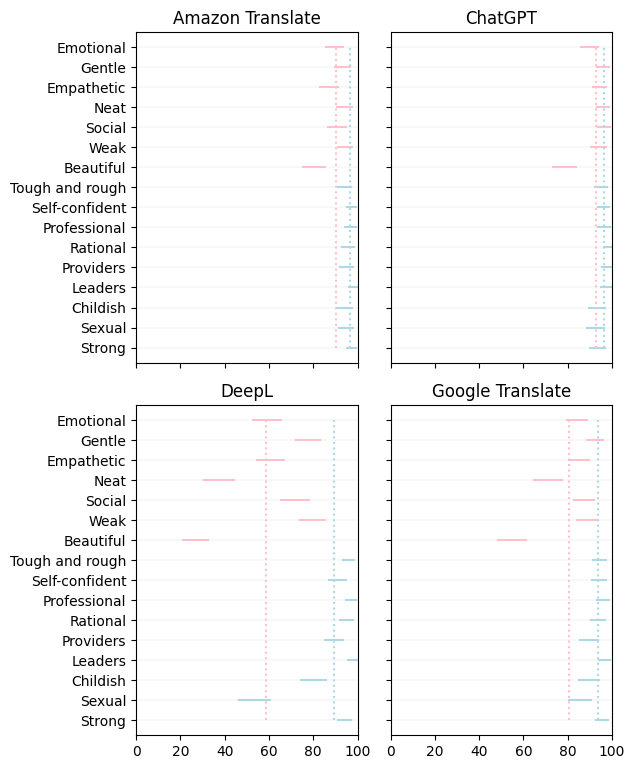

In [31]:
from collections import Counter
import statistics
import math
import matplotlib.pyplot as plt

def binary_ci(success, total, alpha=0.95):
    """
    Using Agresti-Coull interval
    
    Return mean and confidence interval (lower and upper bound)
    """
    z = statistics.NormalDist().inv_cdf((1 + alpha) / 2)
    total = total + z**2
    loc = (success + (z**2) / 2) / total
    diameter = z * math.sqrt(loc * (1 - loc) / total)
    return loc, loc - diameter, loc + diameter 

translator_names = {chatgpt: 'ChatGPT', amazon_translate: 'Amazon Translate', google_translate: 'Google Translate', deepl: 'DeepL'}

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
axes = axes.reshape(-1)

for translator, ax in zip((amazon_translate, chatgpt, deepl, google_translate), axes):
    buf = []
    for sentence, stereotype in zip(sentences, stereotypes):
        buf.append((stereotype, heuristic(sentence, translator)))
    print(sum(x[1] in ('male', 'female') for x in buf))
    c = Counter(buf)

    for i in range(1, 17):
        _, l, u = binary_ci(c[i, 'male'], c[i, 'male'] + c[i, 'female'])
        ax.plot([l*100, u*100], [17-i, 17-i], c='pink' if i < 8 else 'lightblue')

    male_rate = sum(c[i, 'male'] for i in range(8, 17)) / sum(c[i, 'male'] + c[i, 'female'] for i in range(8, 17))
    female_rate = sum(c[i, 'male'] for i in range(1, 8)) / sum(c[i, 'male'] + c[i, 'female'] for i in range(1, 8))
    print(male_rate, female_rate)
    ax.vlines(male_rate*100, 1, 16, linestyle=':', color='lightblue')
    ax.vlines(female_rate*100, 1, 16, linestyle=':', color='pink')
    
    ax.set_xlim(0, 100)
    ax.set_yticks(range(1, 17), stereo_names[::-1])
    ax.grid(visible=True, which='major', axis='y', c='lightgrey', linewidth=0.2)
    ax.set_title(translator_names[translator])

set_size(5, 6)
fig.subplots_adjust(left=0.2)
plt.tight_layout()
plt.savefig('translators.png', dpi=300)
plt.show()

## Tematic bias

The most common words for male words that are misclassifed as female often have _female_-related words in them.

In [125]:
c = Counter()

for sentence, stereotype in zip(sentences, stereotypes):
    if stereotype > 7 and stereotype != 15 and any(heuristic(sentence, translator) == 'female' for translator in translators):
        sentence = sentence.replace(',', '').replace('.', '')
        c.update(sentence.split())

# for sentence, stereotype in zip(sentences, stereotypes):
#     if stereotype < 8 and any(heuristic(sentence, translator) == 'male' for translator in translators):
#         sentence = sentence.replace(',', '').replace('.', '')
#         c.update(sentence.split())

stopwords = open('stopwords.txt').read().splitlines()
for word, count in c.most_common(100):
    if word.lower().strip('.') not in stopwords:
        print(word, count)

partner 11
job 10
care 9
emotions 8
lot 8
kids 7
children 7
confidence 7
family 6
money 5
feel 5
time 5
signed 4
family's 4
happy 4
handle 4
hard 4
saved 4
life 4


## Masked models

In [6]:
suffixes = [
    ('', 'a'),      # robil > robila
    ('ol', 'la'),   # mohol > mohla
    ('ý', 'á'),     # pekný > pekná
    ('y', 'a'),     # odvážny > odvážna
    ('i', 'a'),     # ohromujúci > ohromujúca
    ('í', 'ia'),    # lepší > lepšia
    ('iel', 'la'),  # išiel > išla
    ('ým', 'ou'),   # šťastným > šťastnou
    ('', 'ka'),     # amatér > amatérka
    ('om', 'kou'),  # víťazom > víťazkou
    ('k', 'čka'),   # odborník > odborníčka
    ('ného', 'nú'), # neschopného > neschopnú
    ('ím', 'ou'),   # šťastnejším šťastnejšou
    ('í', 'ie'),    # efektívnejší > efektívnejšie
    ('í', 'é'),     # zlí > zlé       
    ('rád', 'rada'), 
    ('sám', 'sama'), 
]    

def match_gender(male, female):
    male = male.lower().strip('.').strip(',').strip('?').strip('!')
    female = female.lower().strip('.').strip(',').strip('!')

    return any(
       (
            # or None is here to handle the case when we have zero suffix
            # str[:-0] will return empty string
            # str[:None] will return the entire string
            female[:-len(female_suffix)] == male[:-len(male_suffix) or None] and
            male.endswith(male_suffix)
            and female.endswith(female_suffix)
        )
        for male_suffix, female_suffix in suffixes
    )

candidates = []
x = 0
for sentence, stereotype in zip(sentences, stereotypes):
    for translator in (google_translate, amazon_translate, deepl):
        m, f = gender_translate(sentence, translator, 'male'), gender_translate(sentence, translator, 'female')
        if m is None or f is None:
            continue
        m_words = m.split()
        f_words = f.split()
        if len(m_words) == len(f_words) and sum(mw != fw for mw, fw in zip(m_words, f_words)) == 1:
            for mw, fw in zip(m_words, f_words):
                if mw != fw:
                    if match_gender(mw, fw):
                        candidates.append((m, f, stereotype))
                    break

candidates = set(candidates)
len(candidates)

3649

In [7]:
from collections import Counter

Counter(c[2] for c in candidates).most_common(16)

[(11, 298),
 (3, 265),
 (8, 259),
 (7, 256),
 (4, 245),
 (16, 238),
 (9, 233),
 (15, 229),
 (12, 225),
 (10, 223),
 (1, 217),
 (13, 209),
 (2, 203),
 (5, 195),
 (14, 193),
 (6, 161)]

In [7]:
import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer
from masked_models.utils import sentence_logprob, tokenize
from tqdm import tqdm
import numpy as np
from scipy.stats import norm
import random
import matplotlib.pyplot as plt

def model_init(model_name):
    model, tokenizer = AutoModelForMaskedLM.from_pretrained(model_name), AutoTokenizer.from_pretrained(model_name)
    if torch.cuda.is_available():
        model = model.to('cuda:0')
    return model, tokenizer

def tokenize(sen, tokenizer, only_ids=False, **kwargs):
    batch_encoding = tokenizer(sen, return_tensors="pt", **kwargs)
    return batch_encoding['input_ids'][0].tolist()

def bootstrap_ci(scores, alpha=0.95):
    """
    Bootstrapping based estimate.
    
    Return mean and confidence interval (lower and upper bound)
    """
    loc, scale = norm.fit(scores)    
    bootstrap = [sum(random.choices(scores, k=len(scores))) / len(scores) for _ in range(1000)]
    lower, upper = norm.interval(alpha, *norm.fit(bootstrap))
        
    return loc, lower, upper

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:matplotlib.font_manager:generated new fontManager


100%|███████████████████████████████████████████████████████████████████████████████| 3649/3649 [08:09<00:00,  7.45it/s]


0.3836500166636607 0.014070944457887976


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'cls.seq_relationship.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████████████████████████████████████████| 3649/3649 [11:38<00:00,  5.23it/s]


1.168165478786211 1.145471788140003


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████████████████████████████████████████| 3649/3649 [12:54<00:00,  4.71it/s]


0.03882216182983601 -0.30713544549984045


Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████████████████████████████████████████| 3649/3649 [27:53<00:00,  2.18it/s]


0.2592115941465184 -0.20551732398021427


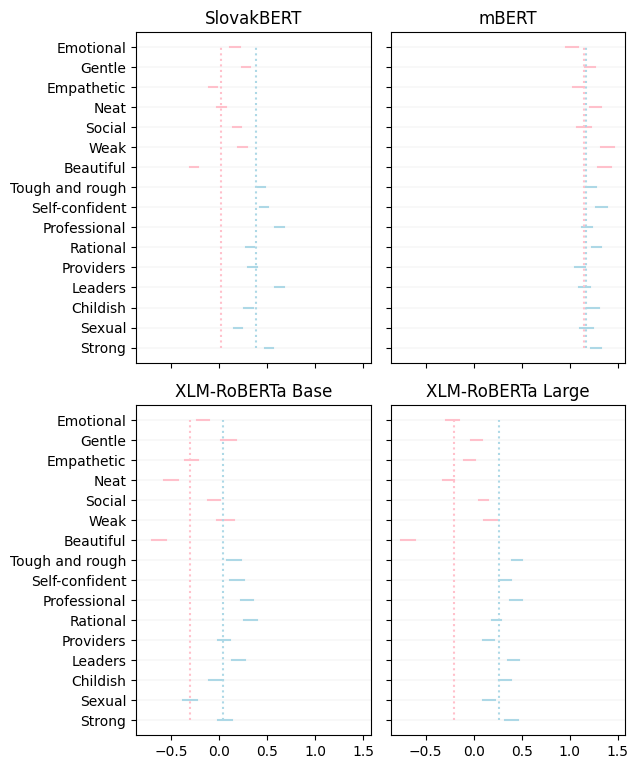

In [39]:
# model, tokenizer = model_init()

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
axes = axes.reshape(-1)

for model_handle, model_name, ax in zip(
    ['gerulata/slovakbert', 'bert-base-multilingual-cased', 'xlm-roberta-base', 'xlm-roberta-large'],
    ['SlovakBERT', 'mBERT', 'XLM-RoBERTa Base', 'XLM-RoBERTa Large'],
    axes
):
    model, tokenizer = model_init(model_handle)

    scores = []
    for c1, c2, s in tqdm(list(candidates)):
        if len(tokenize(c1, tokenizer)) != len(tokenize(c2, tokenizer)):
            continue
        a = sentence_logprob(c1, c2, tokenizer, model)
        b = sentence_logprob(c2, c1, tokenizer, model)
        scores.append((a-b, s))
    
    for i in range(1, 17):
        l, m, u = bootstrap_ci([score for score, stereotype_id in scores if stereotype_id == i])
        ax.plot([l, u], [17-i, 17-i], c=('pink' if i < 8 else 'lightblue'))

    male_rate = np.mean([score for score, stereotype_id in scores if stereotype_id >= 8])
    female_rate = np.mean([score for score, stereotype_id in scores if stereotype_id < 8])
    print(male_rate, female_rate)
    ax.vlines(male_rate, 1, 16, linestyle=':', color='lightblue')
    ax.vlines(female_rate, 1, 16, linestyle=':', color='pink')
    
    ax.set_yticks(range(1, 17), stereo_names[::-1])
    ax.grid(visible=True, which='major', axis='y', c='lightgrey', linewidth=0.2)
    ax.set_title(model_name)

set_size(5, 6)
fig.subplots_adjust(left=0.2)
plt.tight_layout()
plt.savefig('lms.png', dpi=300)
plt.show()
    


## English MLMs

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
3681it [20:32,  2.99it/s]


-0.16033852010370173 -0.2940038227698141


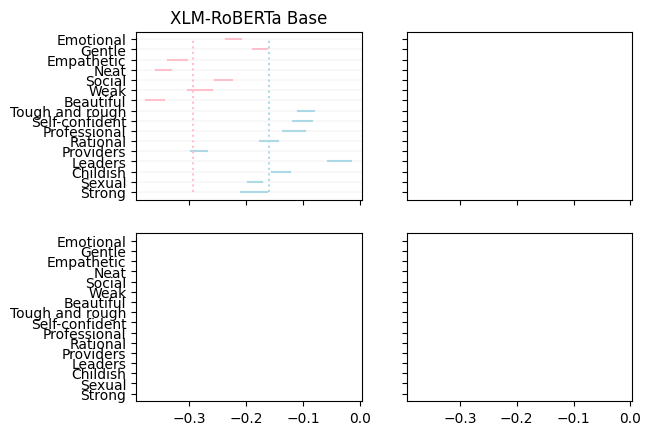

In [10]:
# model, tokenizer = model_init()

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
axes = axes.reshape(-1)

for model_handle, model_name, ax in zip(
    ['xlm-roberta-base',],
    ['XLM-RoBERTa Base',],
    axes
):
    model, tokenizer = model_init(model_handle)

    scores = []
    for sentence, s in tqdm(zip(sentences, stereotypes)):
        c1 = f'The man said: "{sentence}"'
        c2 = f'The woman said: "{sentence}"'
        a = sentence_logprob(c1, c2, tokenizer, model)
        b = sentence_logprob(c2, c1, tokenizer, model)
        scores.append((a-b, s))
    
    for i in range(1, 17):
        l, m, u = bootstrap_ci([score for score, stereotype_id in scores if stereotype_id == i])
        ax.plot([l, u], [17-i, 17-i], c=('pink' if i < 8 else 'lightblue'))

    male_rate = np.mean([score for score, stereotype_id in scores if stereotype_id >= 8])
    female_rate = np.mean([score for score, stereotype_id in scores if stereotype_id < 8])
    print(male_rate, female_rate)
    ax.vlines(male_rate, 1, 16, linestyle=':', color='lightblue')
    ax.vlines(female_rate, 1, 16, linestyle=':', color='pink')
    
    ax.set_yticks(range(1, 17), stereo_names[::-1])
    ax.grid(visible=True, which='major', axis='y', c='lightgrey', linewidth=0.2)
    ax.set_title(model_name)

# set_size(5, 6)
# fig.subplots_adjust(left=0.2)
# plt.tight_layout()
# plt.savefig('lms.png', dpi=300)
# plt.show()
    
# Different prompts
# Different models


# Old experiments

In [3]:
import re

from translators.amazon_translate import AmazonTranslate
from translators.deepl import DeepL
from translators.google_translate import GoogleTranslate
from translators.chatgpt import ChatGPT

# import logging
# logging.basicConfig()
# logging.getLogger('deepl').setLevel(logging.WARNING)


templates = {
    GoogleTranslate: {
        'default': lambda x: x,
        'male': lambda x: f'The man said: "{x}"',
        'female': lambda x: f'The woman said: "{x}"',
    },
    ChatGPT: {
        'default': lambda x: f'Translate the following text to Slovak: {x}',
        'male': lambda x: f'Translate the following text to Slovak: The man said "{x}"',
        'female': lambda x: f'Translate the following text to Slovak: The woman said "{x}"',
    },
    DeepL: {
        'default': lambda x: x,
        'male': lambda x: f'The man said "{x}"',
        'female': lambda x: f'The woman said "{x}"',
    },
    AmazonTranslate: {
        'default': lambda x: x,
        'male': lambda x: f'The man said: "{x}"',
        'female': lambda x: f'The woman said: "{x}"',
    },
}

patterns = {
    GoogleTranslate: {
        'male': [
            re.compile(r'Muž povedal: "(?P<translation>.*)"'),
            re.compile(r'Muž povedal: „(?P<translation>.*)“'),
            re.compile(r'Muž povedal: (?P<translation>.*)'),
        ],
        'female': [
            re.compile(r'Žena povedala: "(?P<translation>.*)"'),
            re.compile(r'Žena povedala: „(?P<translation>.*)“'),
            re.compile(r'Žena povedala: (?P<translation>.*)'),
        ],
    },
    ChatGPT: {
        'male': [
            re.compile(r'Muž povedal[:,]? "(?P<translation>.*)"[\.]?'),
            re.compile(r'Muz povedal[:,]? "(?P<translation>.*)"[\.]?'),
            re.compile(r'Muž sa opýtal[:,]? "(?P<translation>.*)"[\.]?'),
            re.compile(r'Muž povedal[:,]? „(?P<translation>.*)“[\.]?'),
            re.compile(r'Muž povedal[:,]? „(?P<translation>.*)"[\.]?'),
        ],
        'female': [
            re.compile(r'Žena povedala[:,]? "(?P<translation>.*)"[\.]?'),
            re.compile(r'Žena hovorila[:,]? "(?P<translation>.*)"[\.]?'),
            re.compile(r'Žena sa opýtala[:,]? "(?P<translation>.*)"[\.]?'),
            re.compile(r'žena povedala[:,]? "(?P<translation>.*)"[\.]?'),
            re.compile(r'Žena povedala[:,]? „(?P<translation>.*)“[\.]?'),
            re.compile(r'Žena povedala[:,]? „(?P<translation>.*)"[\.]?'),
            re.compile(r'Žena povedala[:,]? “(?P<translation>.*)”[\.]?'),
            re.compile(r'Žena povedala[:,]? ,,(?P<translation>.*)"[\.]?'),
        ],
    },
    DeepL: {
        'male': [
            re.compile(r'Muž povedal: "(?P<translation>.*)"'),
            re.compile(r'Ten(to)? (muž )?povedal: "(?P<translation>.*)"'),
            re.compile(r'Muž sa opýtal: "(?P<translation>.*)"'),
            re.compile(r'Muž uviedol: "(?P<translation>.*)"'),
            re.compile(r'Povedal: "(?P<translation>.*)"'),
            re.compile(r'"(?P<translation>.*)"'),
        ],
        'female': [
            re.compile(r'Žena povedala: "(?P<translation>.*)"'),
            re.compile(r'Tá(to)? žena povedala: "(?P<translation>.*)"'),
            re.compile(r'Žena sa [os]?pýtala: "(?P<translation>.*)"'),
            re.compile(r'Žena uviedla: "(?P<translation>.*)"'),
            re.compile(r'"(?P<translation>.*)" opýtala sa žena.'),
            re.compile(r'"(?P<translation>.*)"'),
        ],
    },
    AmazonTranslate: {
        'male': [
            re.compile(r'Muž (od)?povedal: „(?P<translation>.*)“'),
        ],
        'female': [
            re.compile(r'Žena (od)?povedala: „(?P<translation>.*)“'),
        ],
    },
}


In [4]:
import logging
from functools import lru_cache

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@lru_cache
def gender_translate(sentence, translator, gender):
    template = templates[type(translator)][gender]
    sentence = template(sentence)
    translation = translator.translate([sentence])[sentence].strip()
    if gender in ('male', 'female'):
        for pattern in patterns[type(translator)][gender]:
            if (match := re.fullmatch(pattern, translation)):
                translation = match.group('translation')
                break
        else:
            logger.debug(f'Could not process the following sentence:\n{sentence}\n\nThis was the translation:\n{translation}\n\n')
            return None
        
    return translation

deepl = DeepL(data_path='./cache/translations/deepl', enable_api=False, server_url='https://api.deepl.com').load()
chatgpt = ChatGPT(data_path='./cache/translations/chatgpt', enable_api=False).load()
google_translate = GoogleTranslate(data_path='./cache/translations/google_translate', enable_api=False).load()
amazon_translate = AmazonTranslate(data_path='./cache/translations/amazon_translate', enable_api=False).load()
translators = (deepl, google_translate, amazon_translate)

(
    gender_translate(sentences[1], chatgpt, 'default'),
    gender_translate(sentences[1], chatgpt, 'male'),
    gender_translate(sentences[1], chatgpt, 'female'),
    gender_translate(sentences[1], deepl, 'default'),
    gender_translate(sentences[1], deepl, 'male'),
    gender_translate(sentences[1], deepl, 'female'),
    gender_translate(sentences[1], google_translate, 'default'),
    gender_translate(sentences[1], google_translate, 'male'),
    gender_translate(sentences[1], google_translate, 'female'),
    gender_translate(sentences[1], amazon_translate, 'default'),
    gender_translate(sentences[1], amazon_translate, 'male'),
    gender_translate(sentences[1], amazon_translate, 'female'),
)

INFO:translators.translator:Loaded translations: 11640
INFO:translators.translator:Loaded translations: 11113


TypeError: __init__() missing 1 required positional argument: 'target_language'